In [4]:
import numpy as np
import pandas as pd
import json
import random
from collections import Counter
from sklearn.cluster import KMeans
import requests
from shapely.geometry import Polygon, Point, LineString
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
%matplotlib notebook

### Functions

In [30]:
def sample_point(poly_):
    
    # find bounds of polygon 
    xmin,ymin,xmax,ymax = poly_.bounds
    # select random points within bounds
    point = None
    while point is None:
        random_point = Point(random.uniform(xmin, xmax), random.uniform(ymin, ymax))
        if (random_point.within(poly_)):
            point = random_point
    return (point.x,point.y)

### Load electoral districts

In [31]:
with open('opstillingskreds.geojson','rb') as f:
    shapes = json.load(f)

### sample n points from each electroal district

In [14]:
# there are 92 districts but 300+ shapes, some districts have multiple shapes, so we need to aggregate them
polygons = dict()
for shp in shapes['features']:
    # district id
    shp_name = shp['properties']['OPSTILNAVN']

    # unpack coordinates
    x,y,z = zip(*shp['geometry']['coordinates'][0])
    poly = Polygon(np.array(list(zip(x,y))))
    
    # create polygon
    if shp_name in polygons:
        polygons[shp_name] = polygons[shp_name].union(poly)
    else:
        polygons[shp_name] = poly

In [23]:
# sample points from districts
points = []
# iterate over shapes
for poly_name, poly in polygons.items():
    
    poly_points = []
    # sample multiple points from shape
    for i in range(200):
        lon,lat = sample_point(poly)
        poly_points.append((poly_name,lat,lon))
        
    # to somewhat ensure that points are noverlapping we cluster them using k-means
    geo = list(zip(*poly_points))
    geo = list(zip(geo[1],geo[2]))
    clusters = KMeans(n_clusters=6, n_init=10, max_iter=300, tol=0.0001).fit_predict(np.array(geo))
    # then we select only one point per k-means cluster
    for cluster_id in range(6):
        point_index = random.choice(np.arange(len(clusters))[np.array(clusters)==cluster_id])
        points.append(poly_points[point_index])

### Quick check if points are sampled correctly

<IPython.core.display.Javascript object>


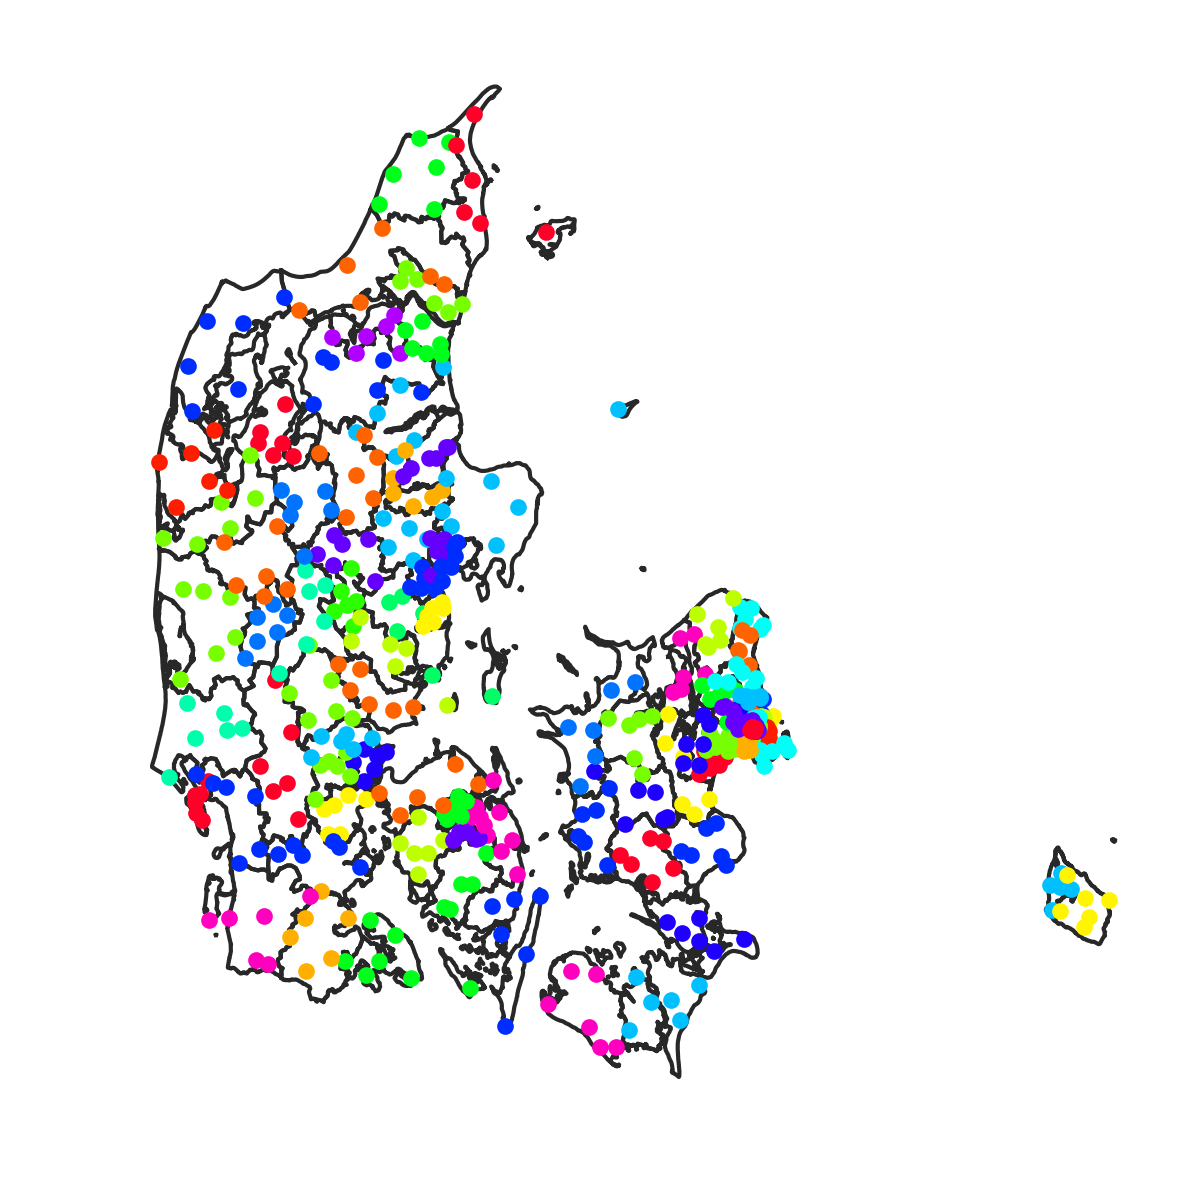

In [13]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)

colors = plt.cm.gist_rainbow(np.linspace(0,1,20))
colors = dict([(n,random.choice(colors)) for n in set(zip(*points)[0])])

# draw outline
for shp in shapes['features']:
    x,y,z = zip(*shp['geometry']['coordinates'][0])
    plt.plot(x,y,color='#282828')

# plot points
for name,lat,lon in points:
    plt.plot(lon,lat,'o',color=colors[name],markersize=5)
    
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Save points data

In [14]:
pd.DataFrame(points,columns=['OPSTILSNAVN','LAT','LON']).to_csv('points_data.csv',index=True,encoding='utf8')

### download images

In [16]:
base = 'https://maps.googleapis.com/maps/api/staticmap?center='
etc = 'zoom=16&size=600x600&maptype=satellite&key='
api = '...API-KEY...'

In [21]:
pic_count = 0
for name,lat,lon in points:
    # construct URL
    p_info = '%f,%f&' % (lat,lon)
    pic_url = base+p_info+etc+api
    
    # download image and save it
    with open('tiles/zoom16/%03d_600x600.png' % pic_count, 'wb') as handle:
        response = requests.get(pic_url, stream=True)

        if not response.ok:
            print response

        for block in response.iter_content(1024):
            if not block:
                break

            handle.write(block)
            
    pic_count += 1